<a href="https://colab.research.google.com/github/mpurkeypile-usd/AAI590-Final_Project/blob/main/AAI590_Final_Project_MPurkeypile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Matt Purkeypile  
AAI590 Capstone: Final Project  
August 2025  

# Breast Tumor Classification Using Quantum Neural Networks

## Setup and library loading

In [3]:
# based on the prototype quantum neural network I did as a proof of concept
# back in April to get the ok for this approach. Notebook for that:
# https://colab.research.google.com/drive/1c2f93b4DxPKU9s4CI8PRZdV_AEoq8ekn
# necessary installs
# cirq works on Python 3.10 and later:
# https://github.com/quantumlib/Cirq/blob/main/docs/start/install.md

#############################################
# Do NOT restart the runtime when prompted! #
#############################################

# based on: https://www.tensorflow.org/quantum/install
# then corrected with AI recommendations
!pip3 install --upgrade pip
!pip3 install tensorflow==2.15.0
!pip3 install -U tensorflow-quantum
!pip install cirq==1.1.0 cirq-google==1.1.0
!pip3 install sympy
!pip install numpy==1.23.5 # Install numpy==1.23.5 to resolve incompatibility

  Using cached cirq_core-1.3.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached cirq_google-1.3.0-py3-none-any.whl.metadata (2.0 kB)
Using cached cirq_core-1.3.0-py3-none-any.whl (1.8 MB)
Using cached cirq_google-1.3.0-py3-none-any.whl (598 kB)
  Attempting uninstall: cirq-core
    Found existing installation: cirq-core 1.1.0
    Uninstalling cirq-core-1.1.0:
      Successfully uninstalled cirq-core-1.1.0
  Attempting uninstall: cirq-google
    Found existing installation: cirq-google 1.1.0
    Uninstalling cirq-google-1.1.0:
      Successfully uninstalled cirq-google-1.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [cirq-google]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cirq-ionq 1.1.0 requires cirq-core==1.1.0, but you have cirq-core 1.3.0 which is incompatible.
cirq 1.1.0 requires cirq-core==1.1.0, but you have cirq-core 1.3.0 which is incompatib

In [1]:
# TODO: FIGURE OUT HOW TO GET THE DEPENDENCIES WORKING IN A RELIABLE WAY
#
# for quantum computing
import tensorflow as tf
import tensorflow_quantum as tfq    # reference: https://www.tensorflow.org/quantum
import cirq                         # reference: https://quantumai.google/cirq/
import cirq_google
from cirq.contrib.svg import SVGCircuit
import sympy

# to load the data
from google.colab import drive

# standard libraries
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns

AttributeError: module 'numpy' has no attribute 'dtypes'

## Data Cleaning

In [ ]:
# first load the data
# note that the file is also in the github repo and could
# be moved into this location or pulled from there.
# original source of data:
# https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset?resource=download
# downloaded June 2025
drive.mount('/content/gdrive')
DATASET_PATH = '/content/gdrive/My Drive/Colab Notebooks/breast-cancer.csv'
TARGET_COL = 'diagnosis'

raw_data = pd.read_csv(DATASET_PATH)

raw_data.describe()
print()
raw_data.info()
print()
raw_data.head()

Mounted at /content/gdrive

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# add in a new column for the diagnosis as a new binary
# variable: 1 (malignant, cancerous), 0 (benign, non-cancerous)
raw_data['diagnosis_binary'] = raw_data['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

print(raw_data['diagnosis_binary'].value_counts())
print(raw_data['diagnosis_binary'].dtype)

diagnosis_binary
0    357
1    212
Name: count, dtype: int64
int64


In [ ]:
# any missing values? (although can see above too)
raw_data.isna().sum()

,0
id,0
diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave points_mean,0


### Data cleaning summary
This data is pretty clean, so nothing really needs to be done to cleanup the data.

## Exploratory Data Analysis

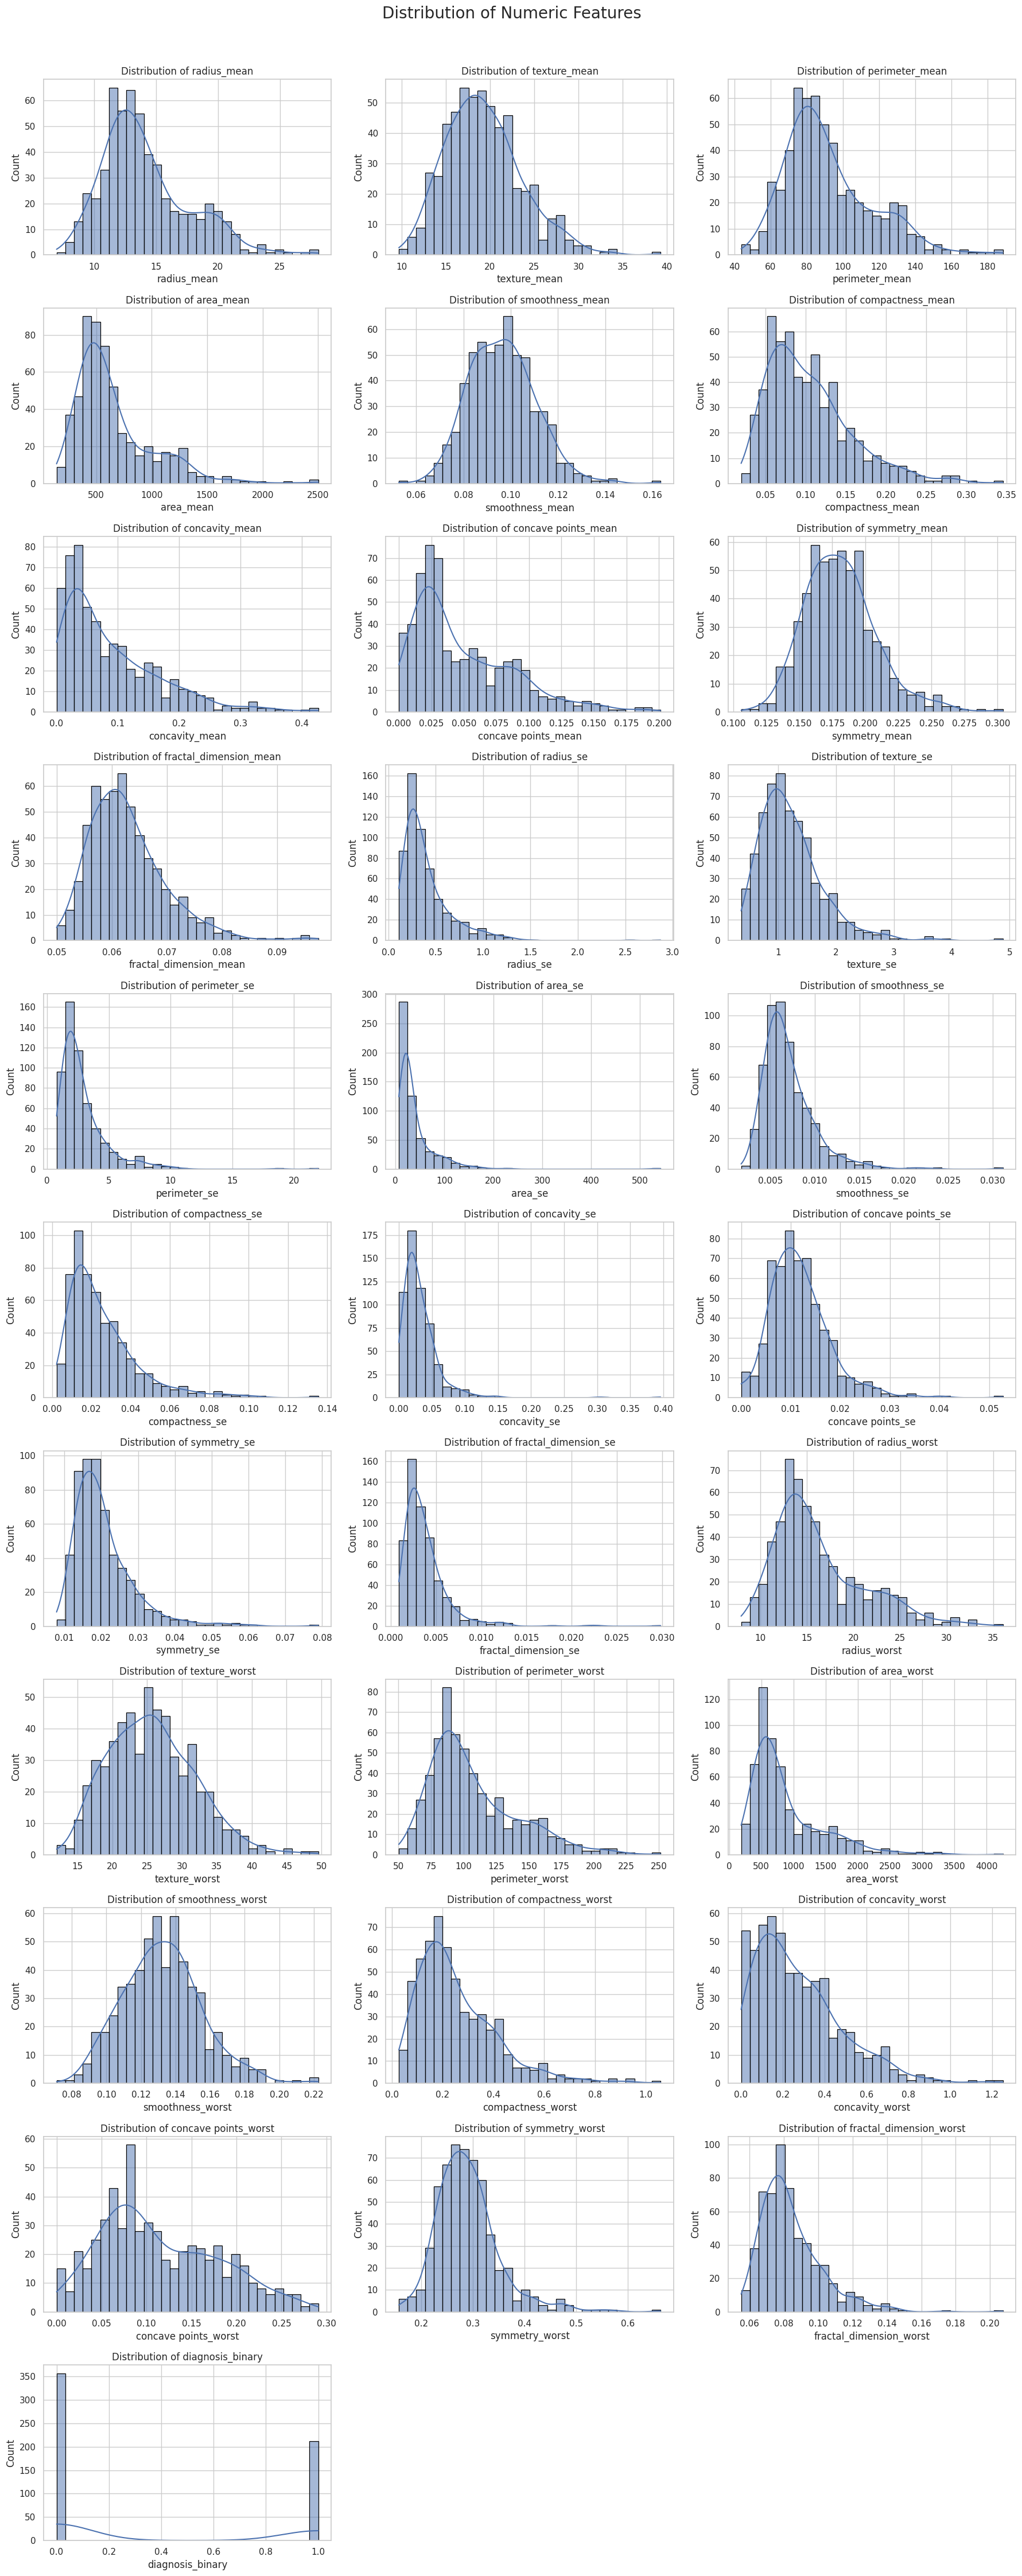

In [ ]:
# based on my AAI540 final project
# Select numeric columns
numeric_cols = raw_data.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop('id')

# Set plot style
sns.set(style="whitegrid")

# Set up the grid
num_plots = len(numeric_cols)
rows = (num_plots // 3) + (num_plots % 3 > 0)
fig, axes = plt.subplots(rows, 3, figsize=(18, 4 * rows))
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numeric_cols):
    sns.histplot(raw_data[col], kde=True, ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution of Numeric Features", fontsize=20, y=1.02)
plt.show()

<Axes: xlabel='diagnosis', ylabel='Count'>

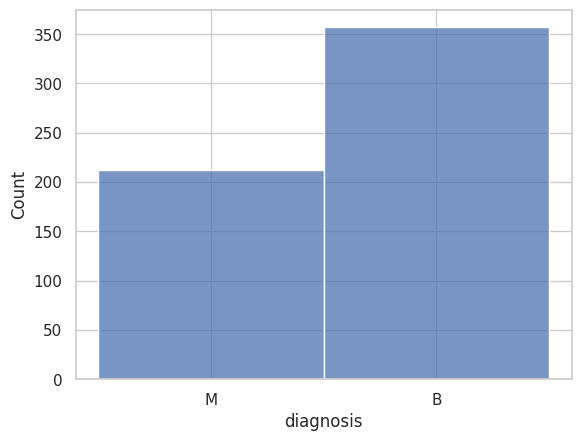

In [ ]:
sns.histplot(raw_data[TARGET_COL])

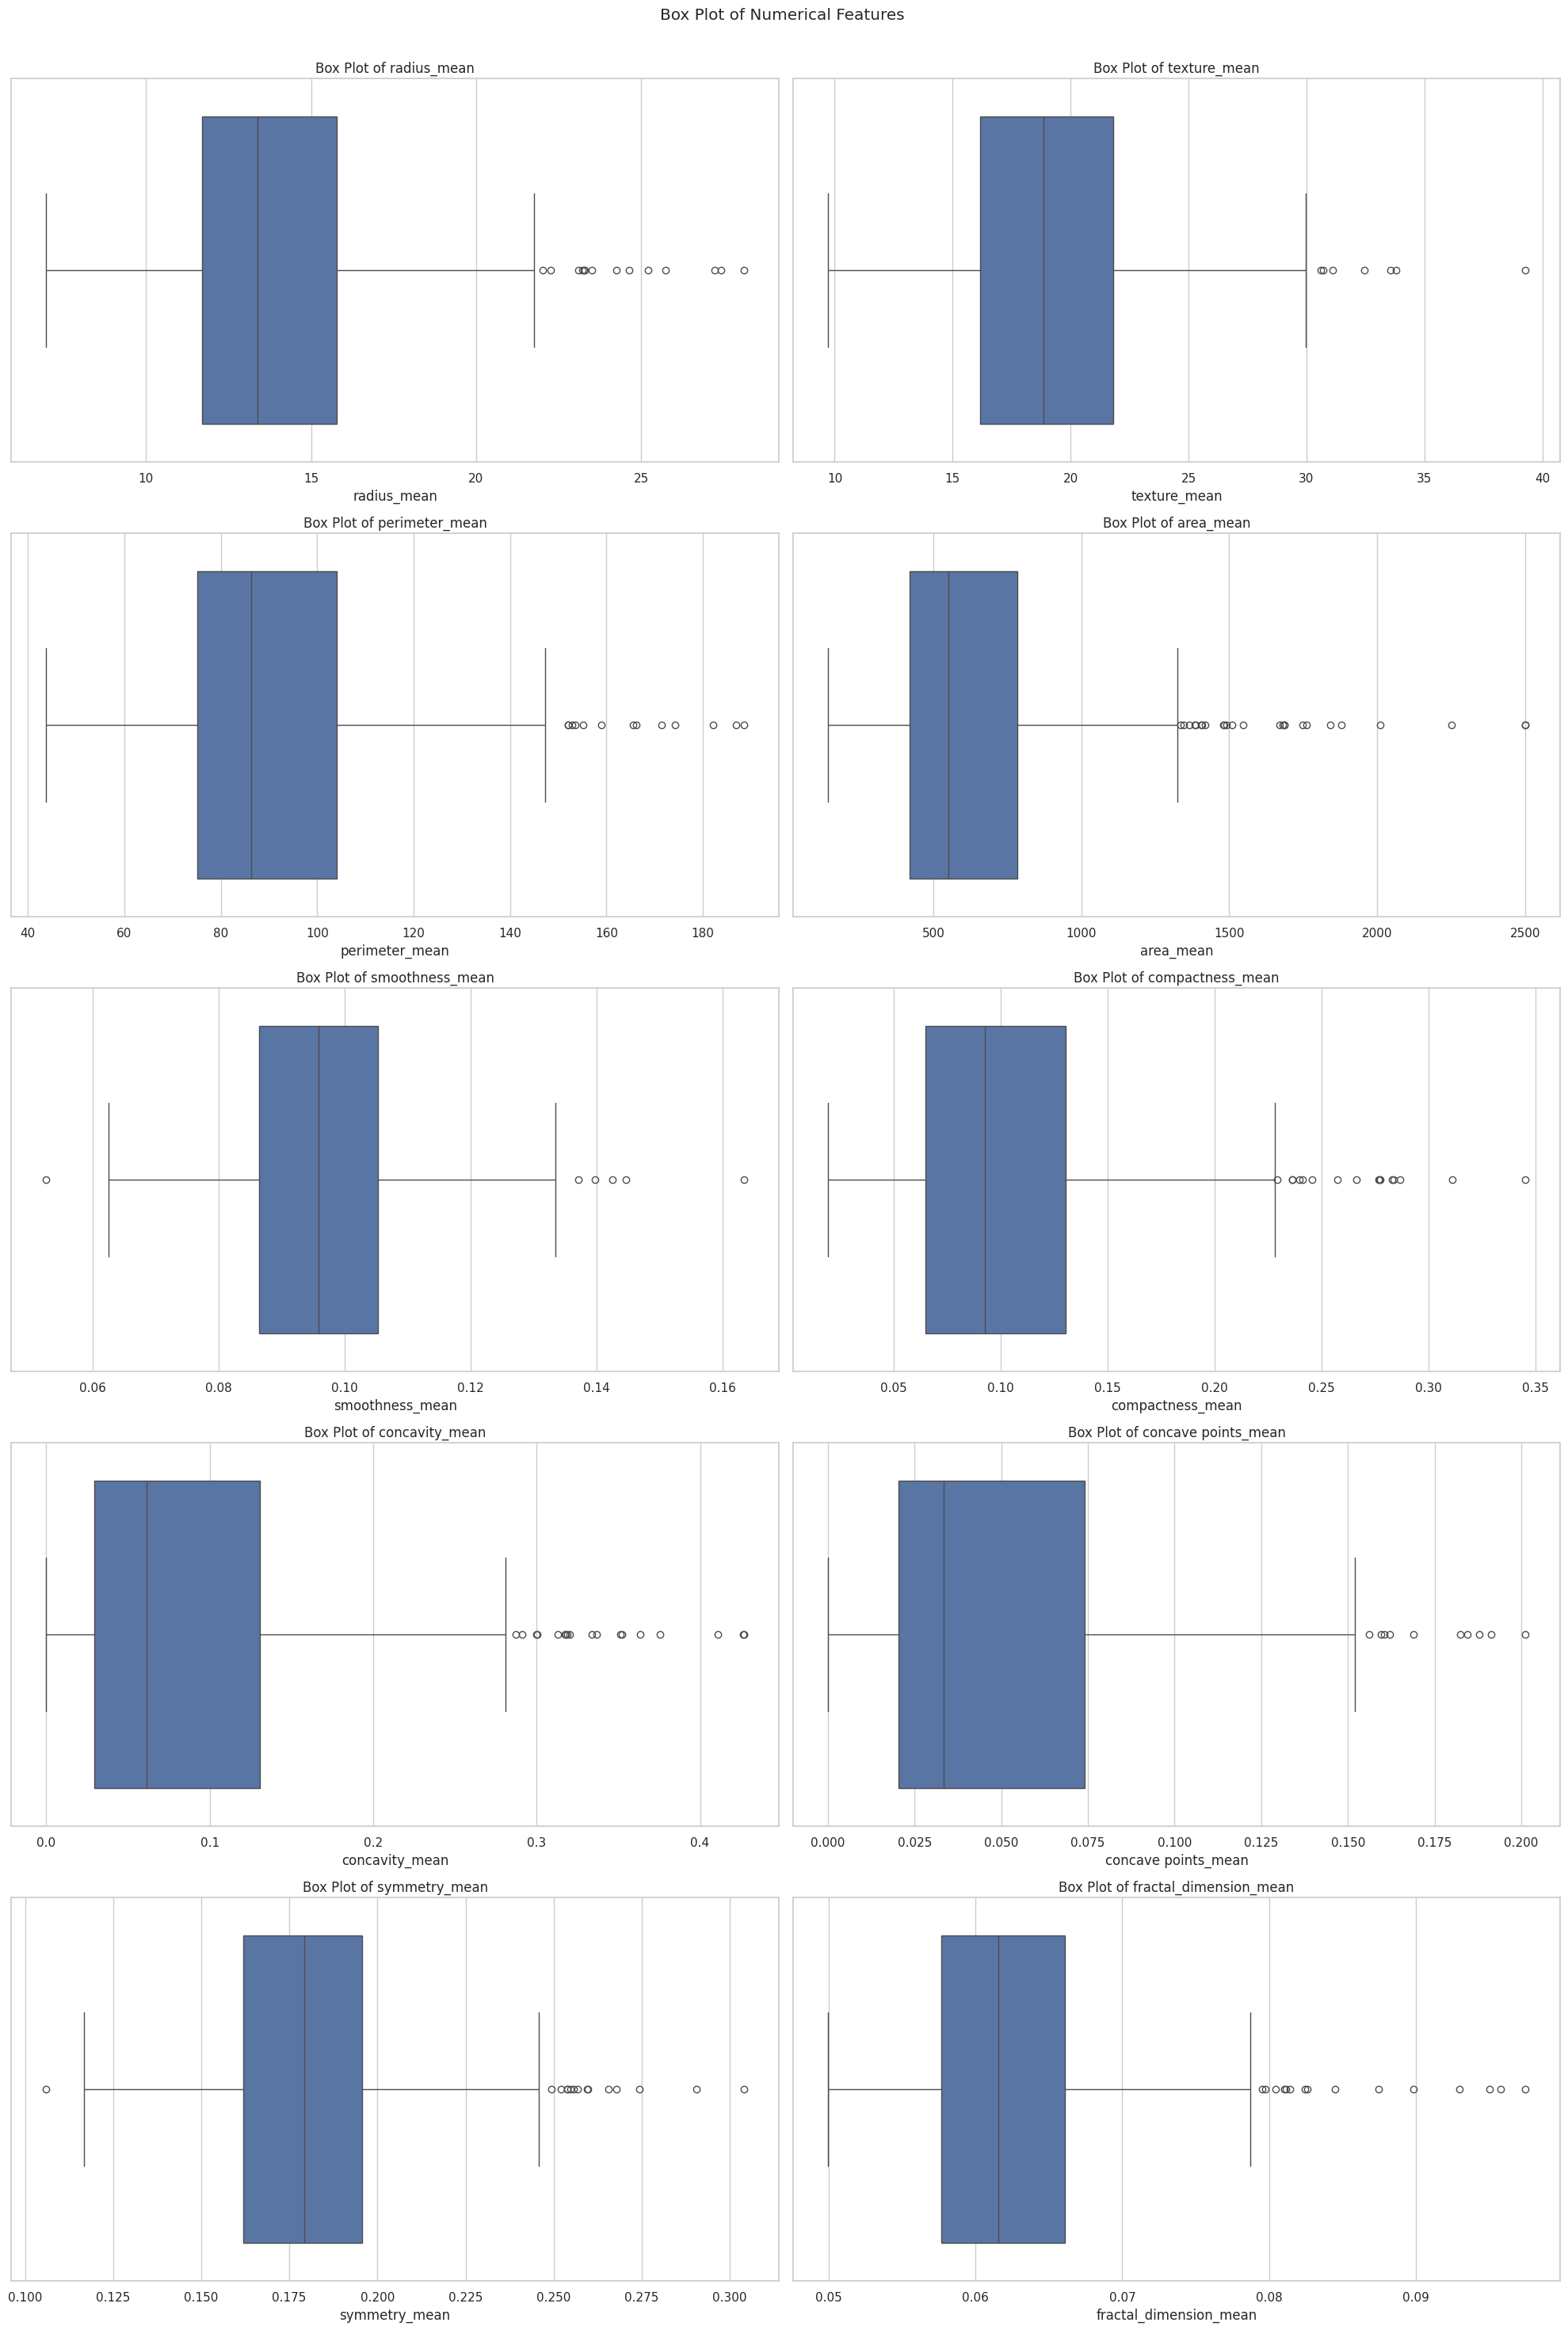

In [ ]:
# This cell based on my AAI540 final project
# Check for Outliers
fig, axes = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle('Box Plot of Numerical Features')

# Iterating over numerical columns
for col, ax in zip(numeric_cols, axes.flatten()):
    sns.boxplot(data=raw_data, x=col, ax=ax)
    ax.set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

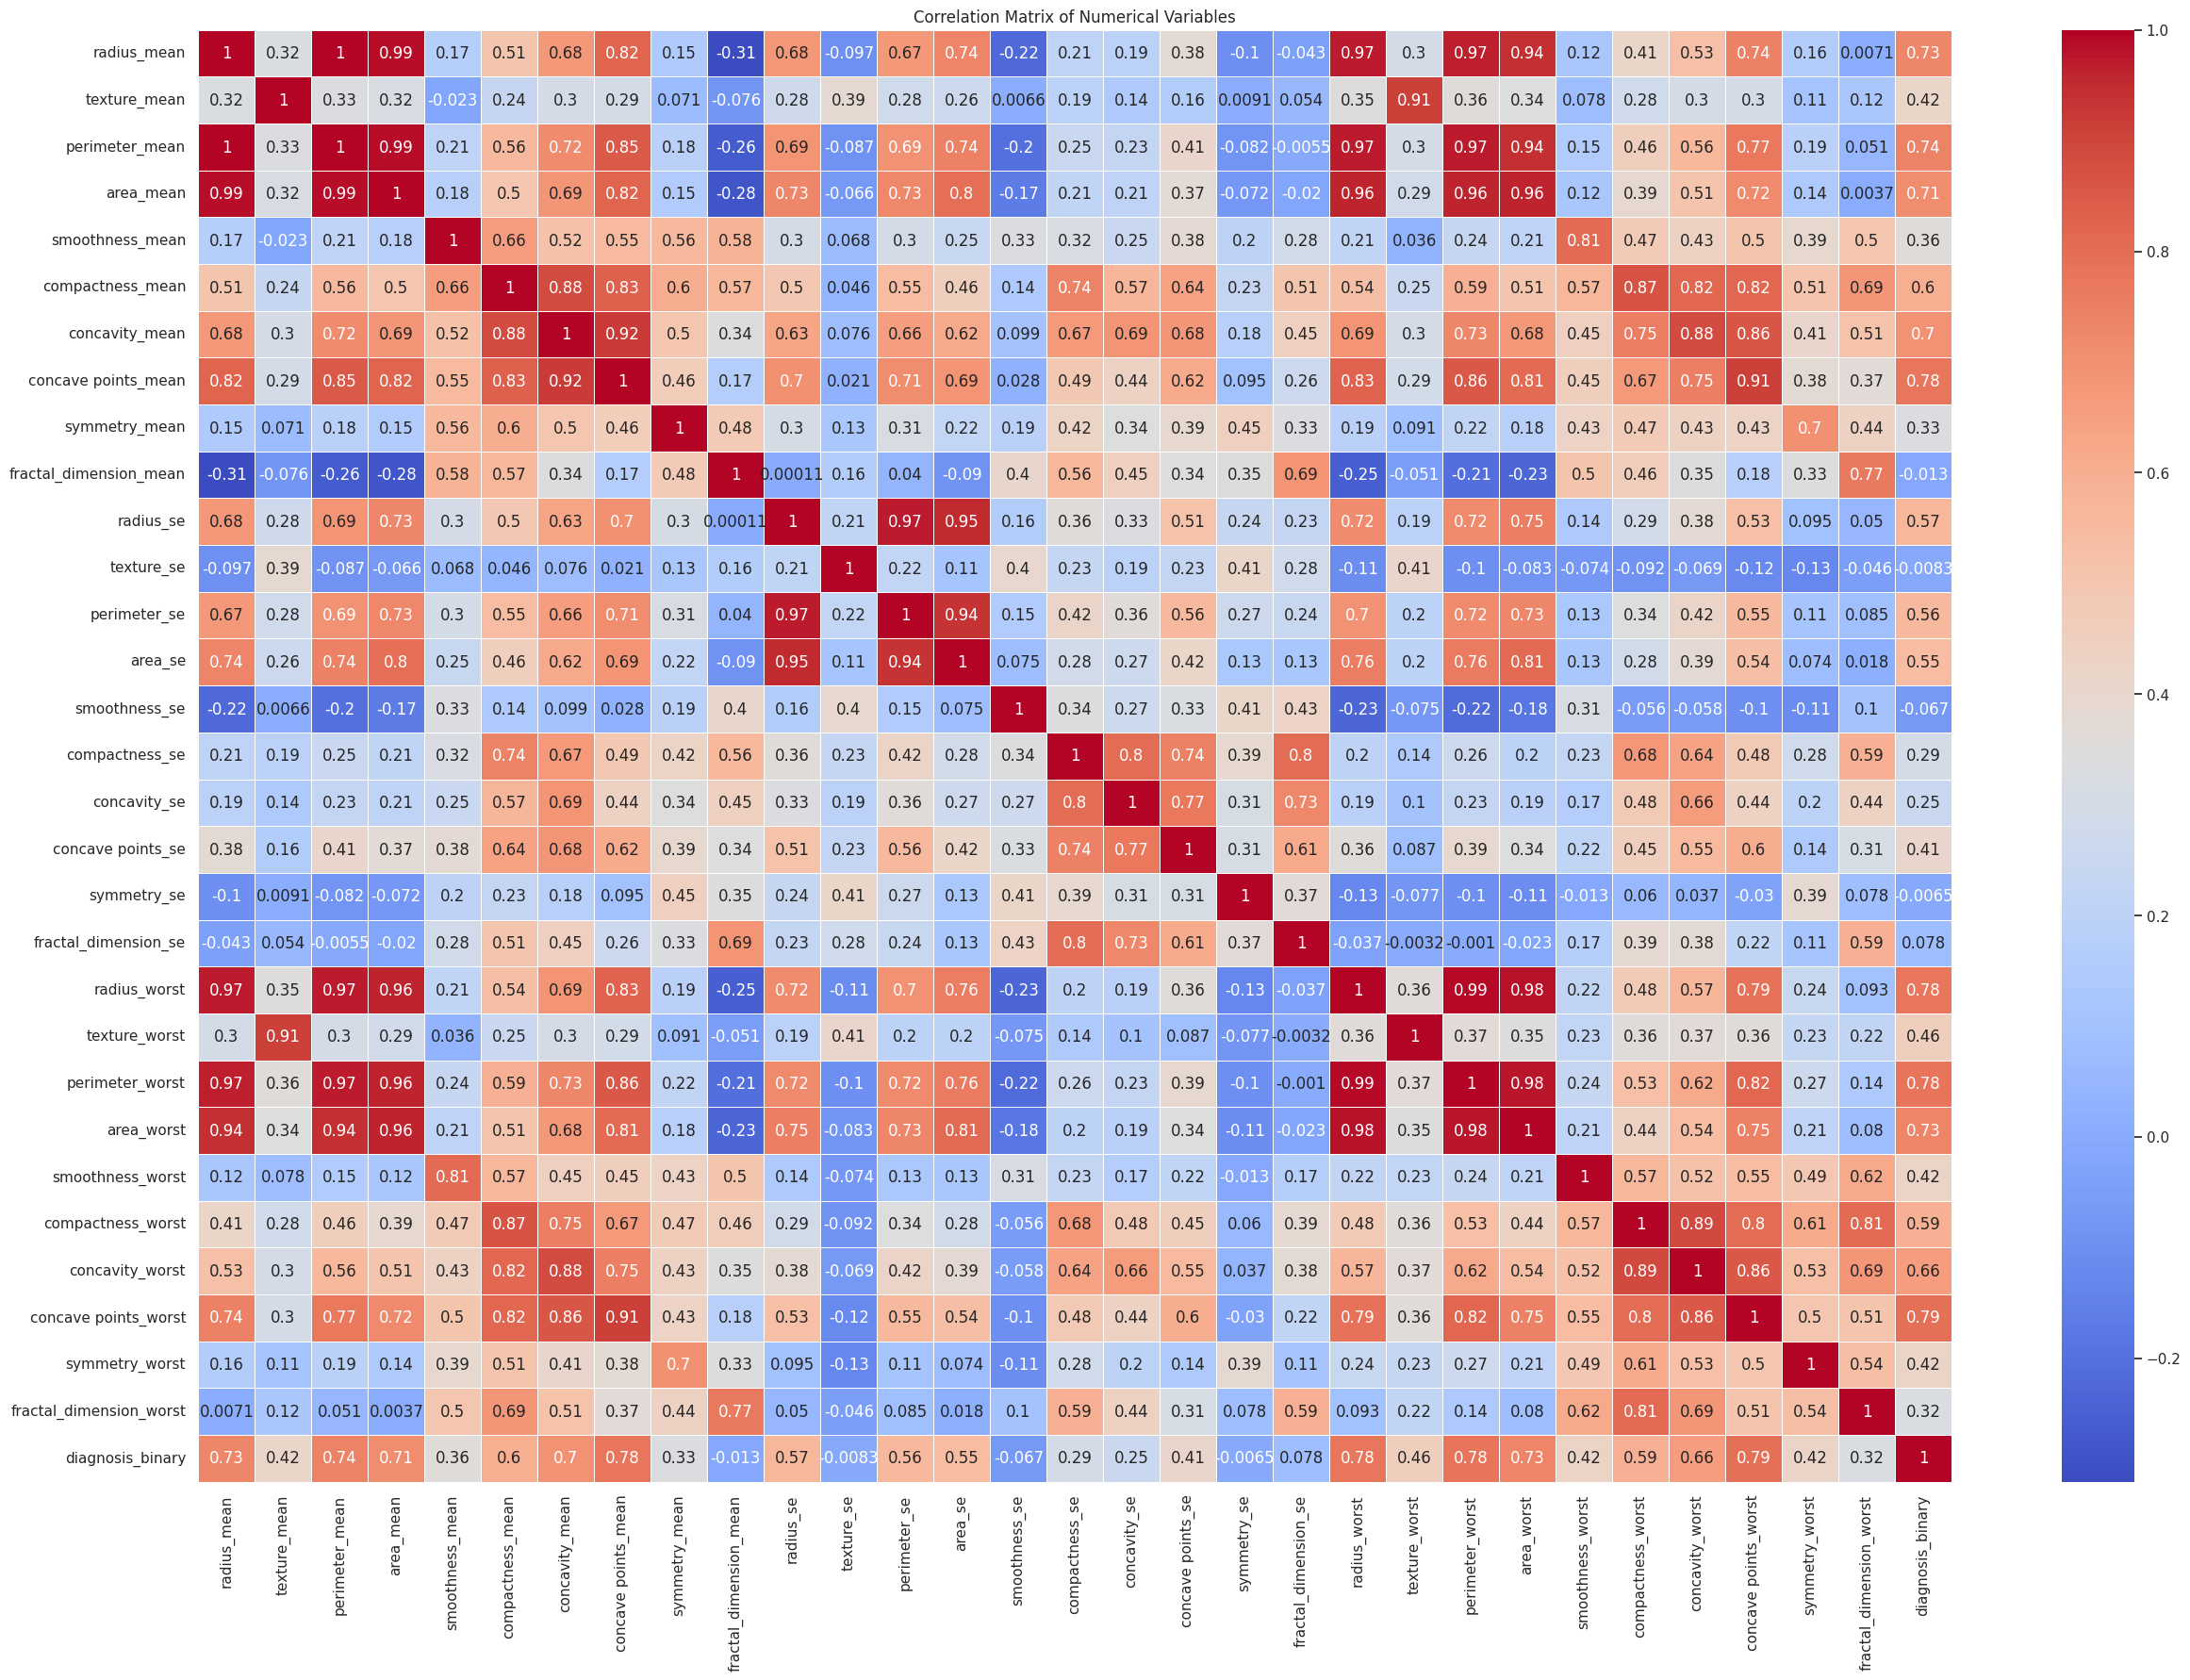

In [ ]:
# based on AAI540 final project
# Correlation matrix & heatmap
correlation_matrix = raw_data[numeric_cols].corr()

plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

## Model Design and Building

### Sample quantum computing
Try out some examples to ensure the environment is setup correctly. Some of this code is from the following:

Pattanayak, S. (2021). Quantum Machine Learning with Python. New York, NY: Singer Science+Business Media.

In [ ]:
# Google's example- make sure the quantum simulation works
# https://quantumai.google/cirq/start/start

#import cirq

# Pick a qubit.
qubit = cirq.GridQubit(0, 0)

# Create a circuit
circuit = cirq.Circuit(
    cirq.X(qubit)**0.5,  # Square root of NOT.
    cirq.measure(qubit, key='m')  # Measurement.
)
print("Circuit:")
print(circuit)

# Simulate the circuit several times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=20)
print("Results:")
print(result)

In [ ]:
# define circuit for classical to quantum data for all datapoints
# and transform those circuits to Tensors using Tensorflow Quantum
def classical_data_to_tfq_tensors(x_train_bin, x_test_bin):
  x_train_c = [classical_to_quantum_data_circuit(x) for x in x_train_bin]
  x_test_c = [classical_to_quantum_data_circuit(x) for x in x_test_bin]
  x_train_tfc = tfq.convert_to_tensor(x_train_c)
  x_test_tfc = tfq.convert_to_tensor(x_test_c)
  return x_train_tfc, x_test_tfc

In [ ]:
class QuantumLayer():
  def __init__(self, data_qubits, readout):
    self.data_qubits = data_qubits
    self.readout = readout

  def add_layer(self, circuit, gate, prefix):
    for i, q in enumerate(self.data_qubits):
      _w_ = sympy.Symbol(prefix + '-' + str(i))
      circuit.append(gate(q, self.readout) ** _w_)

In [ ]:
def create_QNN(resize_dim = 4):
  """ Create a QNN model circuit and prediction(readout) """
  data_qubits = cirq.GridQubit.rect(resize_dim, resize_dim)
  readout = cirq.GridQubit(-1, -1)    # a single qubit at [-1, 1]
  circuit = cirq.Circuit()

  # prep the readout qubit
  circuit.append(cirq.X(readout))
  circuit.append(cirq.H(readout))

  builder = QuantumLayer(data_qubits = data_qubits, readout = readout)

  # apply a series of XX layers followed by a series
  # of ZZ layers
  builder.add_layer(circuit, cirq.XX, 'XX')
  builder.add_layer(circuit, cirq.ZZ, 'ZZ')

  # Hadamard gate on the readout qubit
  circuit.append(cirq.H(readout))

  return circuit, cirq.Z(readout)

In [ ]:
def hinge_accuracy(y_true, y_pred):
  y_true = tf.squeeze(y_true) > 0.0
  y_pred = tf.squeeze(y_pred) > 0.0
  cost = tf.cast(y_true == y_pred, tf.float32)

  return tf.reduce_mean(cost)

## Model Training

## Model Optimization

## Model Analysis